In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel

In [2]:
x = np.arange(100)-50

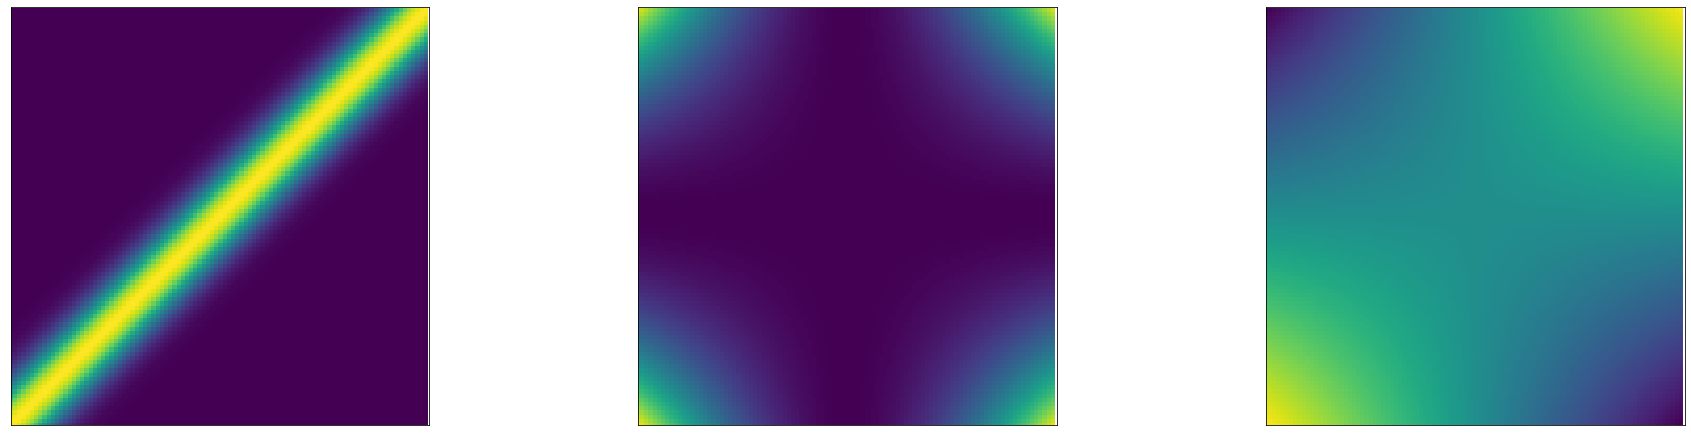

In [3]:
y1 = rbf_kernel(x.reshape(-1,1),gamma=0.01)
y2 = polynomial_kernel(x.reshape(-1,1), degree=2)
y3 = x.reshape(-1,1).dot(x.reshape(1,-1))


fig, ax = plt.subplots(1,3, figsize=(30,10))
for a in ax:
    a.set_ylim((0,100))
    a.set_xlim((0,100))
    a.set_xticks([])
    a.set_yticks([])
ax[0].imshow(y1)
ax[1].imshow(y2)
ax[2].imshow(y3)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
plt.show()

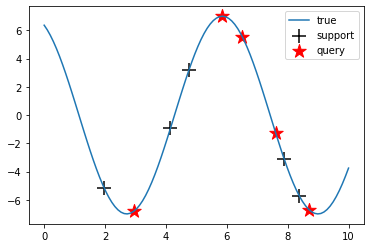

In [150]:
x = np.linspace(0,10,100)
y = 7*np.sin(x+2)

s = np.random.rand(5)*10
ys = 7*np.sin(s+2)


q = np.random.rand(5)*10
yq = 7*np.sin(q+2)

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(x,y, label="true")
ax.scatter(s,ys, c="k", marker="+", s=200, label="support")
ax.scatter(q,yq, c="r", marker="*", s=200, label="query")
plt.legend()
plt.show()

In [4]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [25]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 20)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [26]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [27]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.080   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 1.057   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 1.033   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 1.009   lengthscale: 0.554   noise: 0.555
Iter 5/50 - Loss: 0.984   lengthscale: 0.513   noise: 0.513
Iter 6/50 - Loss: 0.956   lengthscale: 0.474   noise: 0.474
Iter 7/50 - Loss: 0.927   lengthscale: 0.437   noise: 0.438
Iter 8/50 - Loss: 0.894   lengthscale: 0.403   noise: 0.404
Iter 9/50 - Loss: 0.857   lengthscale: 0.371   noise: 0.372
Iter 10/50 - Loss: 0.814   lengthscale: 0.341   noise: 0.342
Iter 11/50 - Loss: 0.767   lengthscale: 0.313   noise: 0.313
Iter 12/50 - Loss: 0.719   lengthscale: 0.286   noise: 0.287
Iter 13/50 - Loss: 0.674   lengthscale: 0.261   noise: 0.262
Iter 14/50 - Loss: 0.634   lengthscale: 0.238   noise: 0.239
Iter 15/50 - Loss: 0.600   lengthscale: 0.218   noise: 0.217
Iter 16/50 - Loss: 0.571   lengthscale: 0.201   noise: 0.198
Iter 17/50 - Loss: 0.545   length

In [28]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

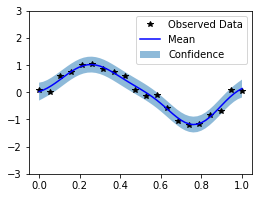

In [29]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

tensor([0.8626, 0.6071, 0.2710, 0.6828, 0.3073])

(100, 10)
[[-0.34932685 -0.13691762 -0.95975924 -0.97740275 -0.04790043 -0.8283941
  -0.8926195  -0.58311534  1.1564057  -0.8339075 ]
 [-0.2157114  -0.36047658 -0.88490844 -0.6911465   0.00198586 -1.0320933
  -0.6334133  -0.6454685   0.9564492  -1.0706893 ]
 [-0.09225914 -0.16300356 -0.8827465  -0.7207838  -0.09615865 -1.1093773
  -0.74075395 -0.6237815   0.9532808  -0.8576318 ]
 [-0.40494153 -0.35419482 -1.1880907  -0.9498614  -0.01068339 -1.0235211
  -0.751787   -0.61355567  0.94604856 -1.0061815 ]
 [-0.28983688 -0.11479041 -1.0778114  -0.569875    0.21146268 -0.877311
  -0.90613204 -0.8185016   0.73395646 -0.73881406]
 [-0.24829417 -0.26726708 -1.1185542  -0.897959    0.0835337  -1.0276848
  -0.8872467  -0.37285987  0.7917943  -0.8455039 ]
 [-0.09128995 -0.30515325 -1.066647   -0.5766336   0.20403776 -1.0717486
  -0.6789634  -0.61258507  0.70317674 -0.9226526 ]
 [-0.42011502 -0.34292218 -0.8948958  -1.147822    0.04462473 -1.1435637
  -1.0226321  -0.53609526  0.9562087  -0.94368446]

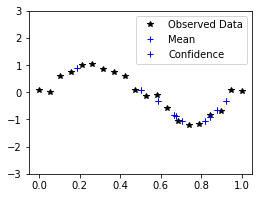

In [49]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.rand(10)
    observed_pred = likelihood(model(test_x))

with torch.no_grad():
    # Initialize plot
    

    samples1 = observed_pred.sample(sample_shape=torch.Size((100,))).numpy()
    samples2 = observed_pred.sample(sample_shape=torch.Size((100,))).numpy()
    samples3 = observed_pred.sample(sample_shape=torch.Size((100,))).numpy()
    
    print(samples1.shape)
    print(samples1)
    
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b+')
    # Shade between the lower and upper confidence bounds
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b+')
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [46]:
torch.Size((100,))

torch.Size([100])

In [50]:
import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9]


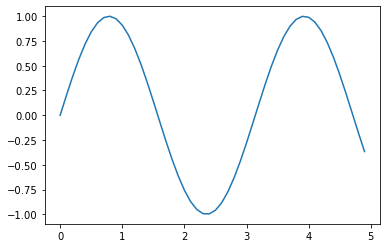

In [79]:
X = np.arange(0, 5,0.1 )
print(X)
y = np.sin((X[:]*2))
plt.plot(X,y)

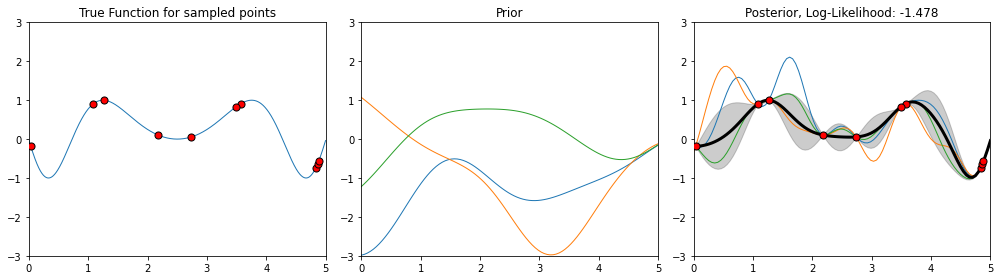

In [125]:
rbf = RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0))
gp = GaussianProcessRegressor(kernel=rbf)

# Plot prior
fig, ax = plt.subplots(1,3,figsize=(14,4))

X_= np.linspace(0, 5, 100)
# y_mean, y_std = gp.predict(X_.reshape(-1,1), return_std=True)
# ax[0].plot(X_, y_mean, 'k', lw=3, zorder=9)
# plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
#                  alpha=0.2, color='k')
y_samples = gp.sample_y(X_[:, np.newaxis], 3)
ax[1].plot(X_, y_samples, lw=1)
ax[1].set_xlim(0, 5)
ax[1].set_ylim(-3, 3)
ax[1].set_title("Prior", fontsize=12)

# Generate data and fit GP
rng = np.random.RandomState(4)
X = rng.uniform(0, 5, 10)[:, np.newaxis]
y = np.sin((X[:, 0] - 2.5) ** 2)
gp.fit(X, y)

# Plot posterior
X_ = np.linspace(0, 5, 100)
y_mean, y_std = gp.predict(X_.reshape(-1,1), return_std=True)
ax[2].plot(X_, y_mean, 'k', lw=3, zorder=9)
ax[2].fill_between(X_, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')

y_samples = gp.sample_y(X_[:, np.newaxis], 3)
ax[2].plot(X_, y_samples, lw=1)
ax[2].scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
ax[2].set_xlim(0, 5)
ax[2].set_ylim(-3, 3)
ax[2].set_title("Posterior, Log-Likelihood: %.3f"
          % (gp.log_marginal_likelihood(gp.kernel_.theta)),
          fontsize=12)


Xt = np.arange(0,5,0.001)[:, np.newaxis]
yt = np.sin((Xt[:, 0] - 2.5) ** 2)


ax[0].plot(Xt, yt, lw=1)
ax[0].scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
ax[0].set_xlim(0, 5)
ax[0].set_ylim(-3, 3)
ax[0].set_title("True Function for sampled points", fontsize=12)

plt.tight_layout()

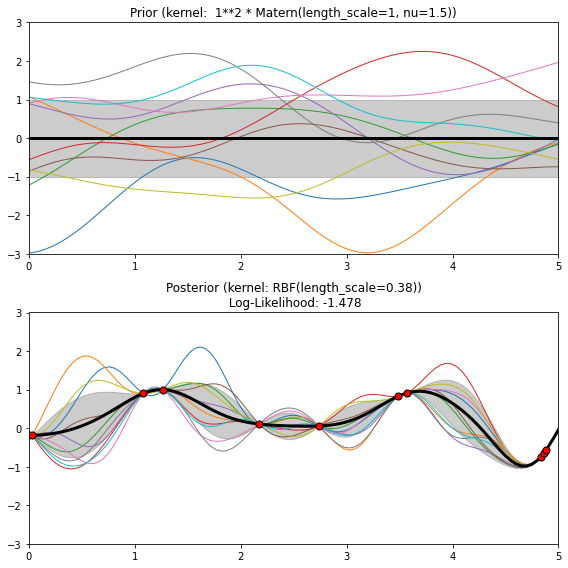

Automatically created module for IPython interactive environment


/home/anowak/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/home/anowak/miniconda3/envs/py3/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


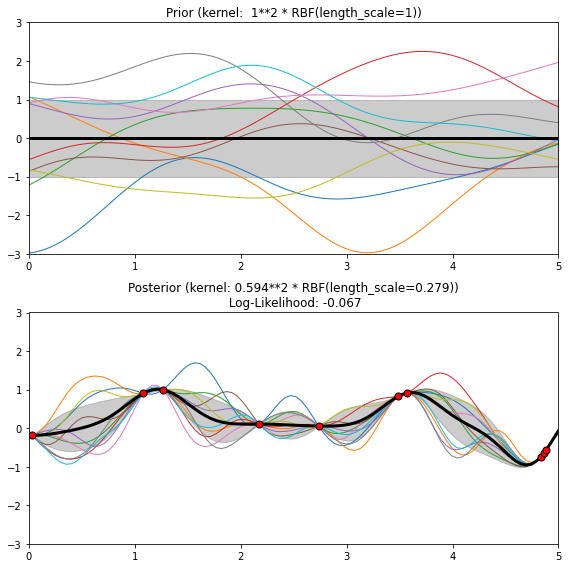

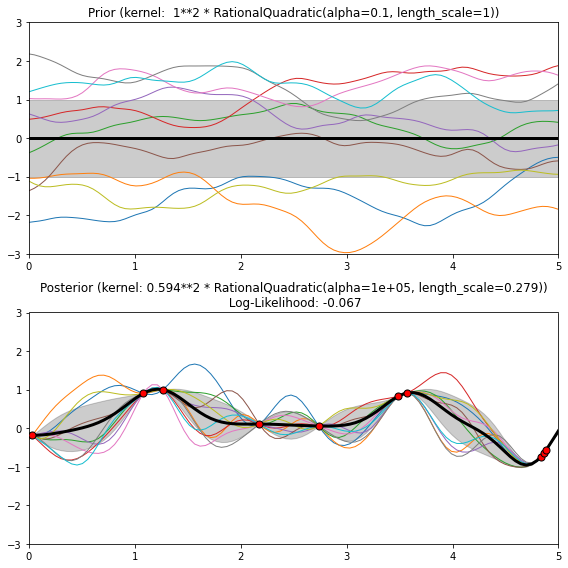

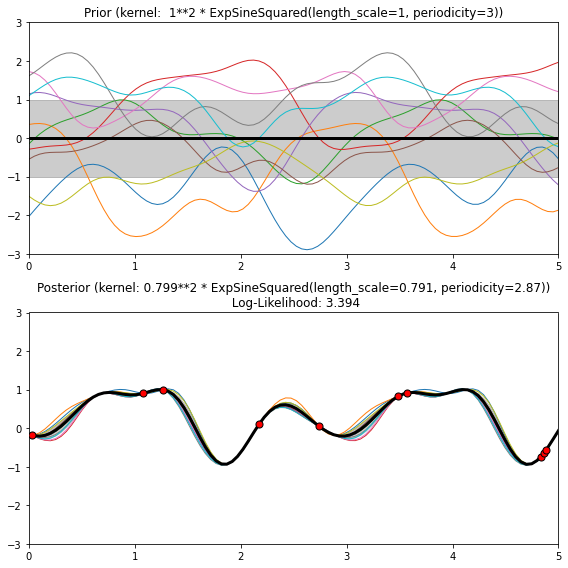

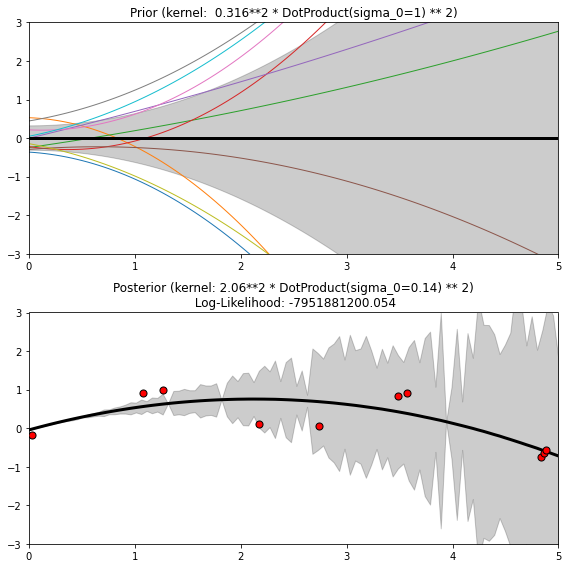

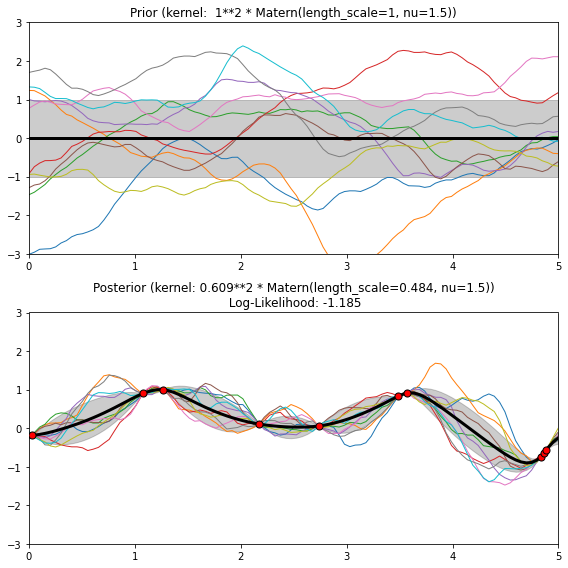

In [85]:
print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import numpy as np

from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           ConstantKernel(0.1, (0.01, 10.0))
               * (DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) ** 2),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

for kernel in kernels:
    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel)

    # Plot prior
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)

    # Generate data and fit GP
    rng = np.random.RandomState(4)
    X = rng.uniform(0, 5, 10)[:, np.newaxis]
    y = np.sin((X[:, 0] - 2.5) ** 2)
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    X_ = np.linspace(0, 5, 100)
    y_mean, y_std = gp.predict(X_[:, np.newaxis], return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_, y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_[:, np.newaxis], 10)
    plt.plot(X_, y_samples, lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(0, 5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()

plt.show()